In [1]:
# python src/data/project2/dataloader_validation.py

from src.data.project2.dataloader import get_loaders
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

import torch

In [2]:
################

from collections import deque
import sklearn
import glob
import PIL.Image as Image
import random
import os
from torchvision import transforms
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np


# Get loaders function
from torch.utils.data import DataLoader

def NoOp(image, **kwargs):
    return image

def get_loaders(dataset, batch_size=2, seed=1, num_workers=1, augmentations:dict={'rotate': False, 'flip': False}):

    if dataset == 'DRIVE':
        img_size = (256, 256)

        train_transform = A.Compose([
                        A.Resize(img_size[0], img_size[1]),
                        A.Rotate(limit=20, p=0.5) if augmentations['rotate'] else A.Lambda(NoOp, NoOp),
                        A.HorizontalFlip(p=0.5) if augmentations['flip'] else A.Lambda(NoOp, NoOp),
                        ToTensorV2() # does the same as transforms.ToTensor()
                    ], is_check_shapes=False) 
        test_transform = A.Compose([
                A.Resize(img_size[0], img_size[1]),
                ToTensorV2() # does the same as transforms.ToTensor()
            ], is_check_shapes=False) 
        
        # train_transform = transforms.Compose([transforms.Resize(img_size), 
        #                                 transforms.ToTensor()])

        # testval_transform = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])

        return {
            fold: {
                'train': DataLoader(
                    DRIVE(mode='train', fold=fold, transform=train_transform),
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=num_workers,
                ),
                'test': DataLoader(
                    DRIVE(mode='test', fold=fold, transform=test_transform),
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=num_workers,
                ),
                'validation': DataLoader(
                    DRIVE(mode='val', fold=fold, transform=test_transform),
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=num_workers,
                ),
            }
            for fold in range(20)
        }
    
    elif dataset == 'PH2':
        return _extracted_from_get_loaders_(batch_size, num_workers, augmentations)
    else:
        raise ValueError('unknown dataset')
    

# TODO Rename this here and in `get_loaders`
def _extracted_from_get_loaders_(batch_size, num_workers, augmentations):
    # won't work if halving in the CNN structure will end up with an odd number, numbers must be divisible by 2^N
    img_size = (560, 768)
    
    train_transform = A.Compose([
                        A.Resize(img_size[0], img_size[1]),
                        A.Rotate(limit=20, p=0.5) if augmentations['rotate'] else A.Lambda(NoOp, NoOp),
                        A.HorizontalFlip(p=0.5) if augmentations['flip'] else A.Lambda(NoOp, NoOp),
                        ToTensorV2() # does the same as transforms.ToTensor()
                    ], is_check_shapes=False) 
    test_transform = A.Compose([
                A.Resize(img_size[0], img_size[1]),
                ToTensorV2() # does the same as transforms.ToTensor()
            ], is_check_shapes=False) 

    trainset = PH2_dataset(mode='train', transform=train_transform)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    valset = PH2_dataset(mode='val', transform=test_transform)
    val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    testset = PH2_dataset(mode='test', transform=test_transform)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return {'train': train_loader, 'validation': val_loader, 'test': test_loader}



## Dataset classes - DRIVE
class DRIVE(torch.utils.data.Dataset):
    def __init__(self, mode = 'train', fold = 0, transform = transforms.ToTensor(), data_path='/dtu/datasets1/02514/DRIVE', seed=420):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'training')
        self.image_paths = sorted(glob.glob(f'{data_path}/images/*.tif'))
        self.label_paths = sorted(glob.glob(f'{data_path}/1st_manual/*.gif'))

        # Shuffling
        self.image_paths, self.label_paths = sklearn.utils.shuffle(self.image_paths, self.label_paths, random_state=seed)

        # rolling 
        self.image_paths, self.label_paths = deque(self.image_paths), deque(self.label_paths)
        self.image_paths.rotate(fold)
        self.label_paths.rotate(fold)

        # converting to list
        self.image_paths, self.label_paths = list(self.image_paths), list(self.label_paths)

        if mode == 'val':
            self.image_paths, self.label_paths = self.image_paths[15:-1], self.label_paths[15:-1]

        elif mode == 'train':
            self.image_paths, self.label_paths = self.image_paths[:15], self.label_paths[:15]

        elif mode == 'test':
            self.image_paths, self.label_paths = self.image_paths[-1:], self.label_paths[-1:]
            
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = np.array(Image.open(image_path))/ 255 
        image = image.astype(np.float32)
        label =  np.array(Image.open(label_path)) * 1.0
        transformed = self.transform(image=image, mask=label)
        X = transformed['image']
        Y = transformed['mask'].unsqueeze(0)

        return X, Y
    
## Dataset classes - PH2
class PH2_dataset(torch.utils.data.Dataset):
    def __init__(self, mode, transform, data_path='/dtu/datasets1/02514/PH2_Dataset_images', seed=420):
        # Initialization
        #data_path = '/Users/arond.jacobsen/Desktop/DTU/8_semester/02514_Deep_Learning_in_Computer_Vision/2_part/0_project/sample_data/PH2_Dataset_images'
        
        self.transform = transform
        self.image_paths = glob.glob(f'{data_path}/*/*_Dermoscopic_Image/*.bmp')
        self.label_paths = glob.glob(f'{data_path}/*/*_lesion/*.bmp')
        c = list(zip(self.image_paths, self.label_paths))
        random.seed(seed)
        random.shuffle(c)
        self.image_paths, self.label_paths = zip(*c)        

        train_size = int(0.7 * len(self.image_paths))
        val_size = int(0.1 * len(self.image_paths))

        if mode == 'train':
            self.image_paths = self.image_paths[:train_size]
            self.label_paths = self.label_paths[:train_size]

        elif mode == 'val':
            self.image_paths = self.image_paths[train_size:train_size+val_size]
            self.label_paths = self.label_paths[train_size:train_size+val_size]

        elif mode == 'test':
            self.image_paths = self.image_paths[train_size+val_size:]
            self.label_paths = self.label_paths[train_size+val_size:]

        else:
            raise ValueError('mode must be one of train, val or test')

        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        
        # Albumentations
        image = np.array(Image.open(image_path)) / 255 
        image = image.astype(np.float32)
        label =  np.array(Image.open(label_path)) * 1.0
        transformed = self.transform(image=image, mask=label)
        X = transformed['image']
        Y = transformed['mask'].unsqueeze(0)
    
        return X, Y 

## DRIVE

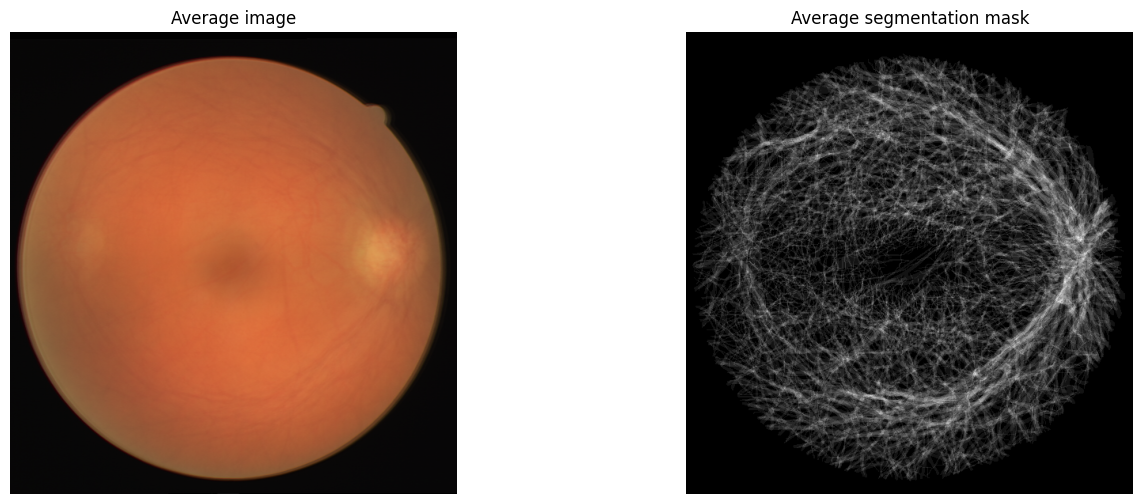

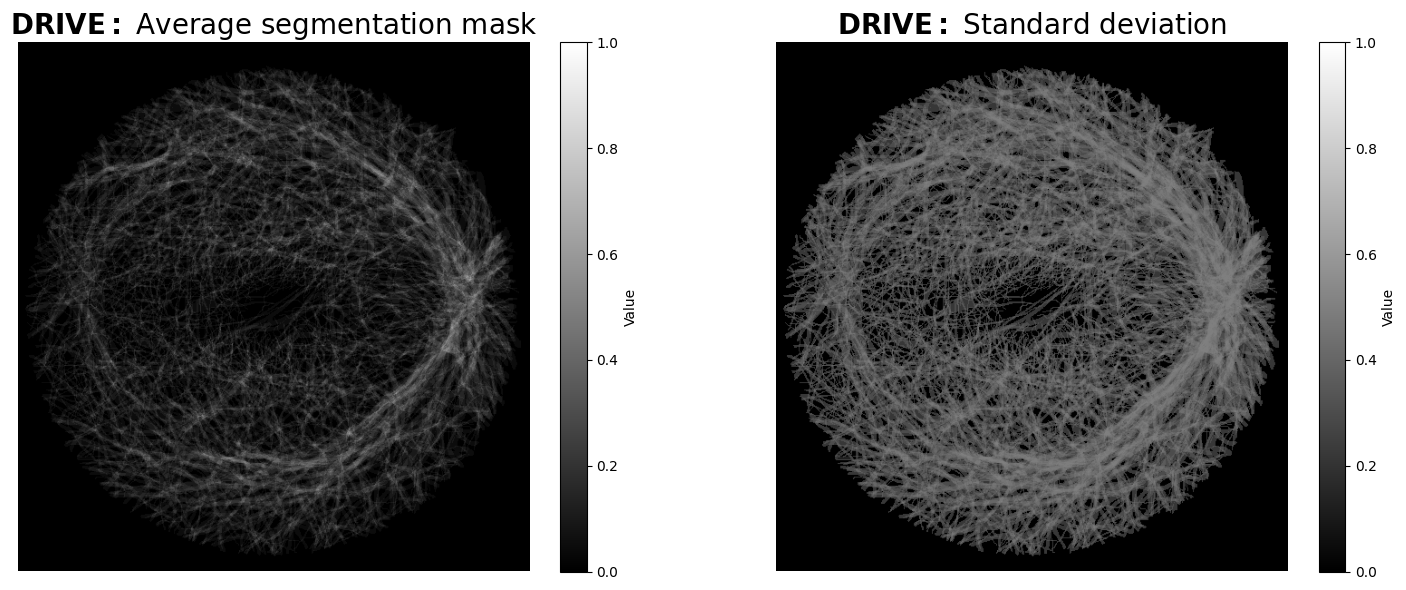

In [ ]:
loaders = get_loaders(
    dataset='DRIVE', 
    batch_size=20, 
    seed=0, 
    num_workers=1,
    # augmentations={'rotate': True, 'flip': True}
)

img_paths = []

img_paths += loaders[0]['train'].dataset.image_paths
img_paths += loaders[0]['test'].dataset.image_paths
img_paths += loaders[0]['validation'].dataset.image_paths

imgs = []
for path in img_paths:
    imgs.append(np.array(Image.open(path)))
imgs = np.stack(imgs)

label_paths = []

label_paths += loaders[0]['train'].dataset.label_paths
label_paths += loaders[0]['test'].dataset.label_paths
label_paths += loaders[0]['validation'].dataset.label_paths

labels = []
for path in label_paths:
    labels.append(np.array(Image.open(path)))
labels = np.stack(labels)



fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(imgs.mean(axis=0) / 255)
axs[0].axis('off')
axs[0].set_title('Average image')

axs[1].imshow(labels.mean(axis=0) / 255, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Average segmentation mask')

plt.show()


fig, axs = plt.subplots(1, 2, figsize=(16, 6))
im1 = axs[0].imshow(labels.mean(axis=0) / 255, cmap='gray', vmin=0.0, vmax=1.0)
axs[0].axis('off')
axs[0].set_title('$\mathbf{DRIVE:}$ Average segmentation mask', fontsize=20)

im2 = axs[1].imshow(labels.std(axis=0) / 255, cmap='gray', vmin=0.0, vmax=1.0)
axs[1].axis('off')
axs[1].set_title('$\mathbf{DRIVE:}$ Standard deviation', fontsize=20)

cbar = plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
cbar.set_label('Value')

cbar = plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
cbar.set_label('Value')

plt.tight_layout()
plt.show()

In [6]:
h, w = labels.shape[1:] 
total_pixels = h * w
print(h, w)

avg_pixel_per_image = (labels / 255).sum(axis=(1, 2)).mean()
lower = np.percentile((labels / 255).sum(axis=(1, 2)), 2.5)
upper = np.percentile((labels / 255).sum(axis=(1, 2)), 97.5)


std_pixel_per_image = (labels / 255).sum(axis=(1, 2)).std()


fraction = avg_pixel_per_image / total_pixels

print(f"\nAverage number of positive pixels: {avg_pixel_per_image} / {total_pixels} ({fraction * 100:.3f}%)")
print(f"95% (bootstrap) CI of positive pixels: [{lower / total_pixels * 100:.3f}; {upper / total_pixels * 100:.3f}] %")

print(f"\nStandard deviation of positive pixels: {std_pixel_per_image:.3f}")


584 565

Average number of positive pixels: 28480.75 / 329960 (8.632%)
95% (bootstrap) CI of positive pixels: [6.293; 11.248] %

Standard deviation of positive pixels: 4185.836


In [7]:
584 * 565

329960

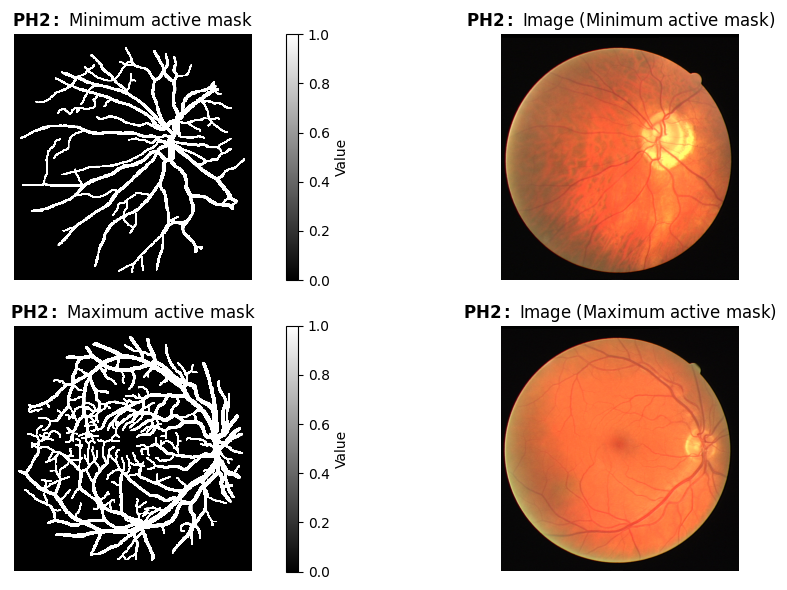

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 6))

im_min = axs[0, 0].imshow(labels[labels.sum(axis=(1,2)).argmin().item()], cmap='gray', vmin=0.0, vmax=1.0)
axs[0, 0].axis('off')
axs[0, 0].set_title('$\mathbf{PH2:}$ Minimum active mask')

im_max = axs[1, 0].imshow(labels[labels.sum(axis=(1,2)).argmax().item()], cmap='gray', vmin=0.0, vmax=1.0)
axs[1, 0].axis('off')
axs[1, 0].set_title('$\mathbf{PH2:}$ Maximum active mask')


axs[0, 1].imshow(imgs[labels.sum(axis=(1,2)).argmin()])
axs[0, 1].axis('off')
axs[0, 1].set_title('$\mathbf{PH2:}$ Image (Minimum active mask)')


axs[1, 1].imshow(imgs[labels.sum(axis=(1,2)).argmax()])
axs[1, 1].axis('off')
axs[1, 1].set_title('$\mathbf{PH2:}$ Image (Maximum active mask)')

cbar = plt.colorbar(im_min, ax=axs[0, 0], fraction=0.046, pad=0.04)
cbar.set_label('Value')

cbar = plt.colorbar(im_max, ax=axs[1, 0], fraction=0.046, pad=0.04)
cbar.set_label('Value')

plt.tight_layout()
plt.show()

## PH2

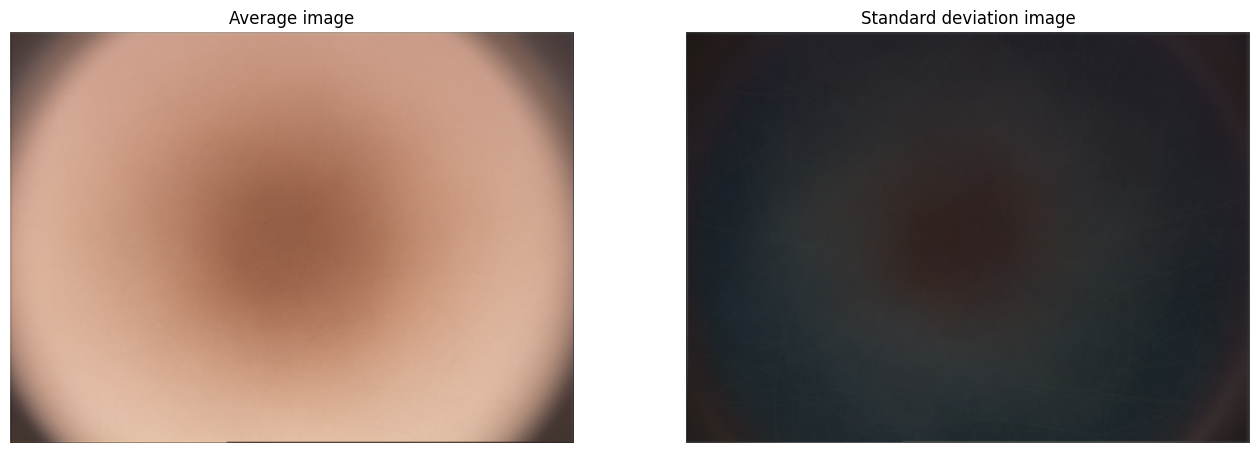

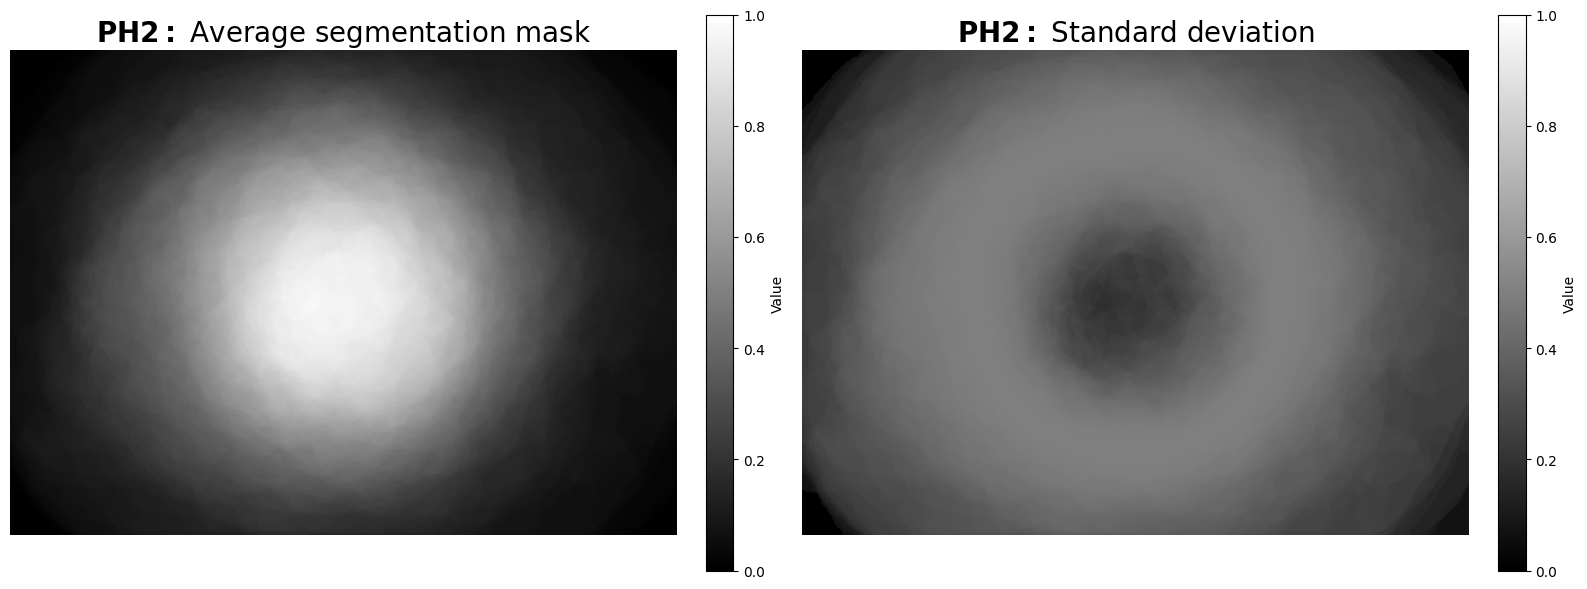

In [10]:
loaders = get_loaders(
    dataset='PH2', 
    batch_size=200, 
    seed=0, 
    num_workers=1,
    # augmentations={'rotate': True, 'flip': True}
)

train_data = next(iter(loaders['train'])) 
test_data  = next(iter(loaders['test'])) 
val_data   = next(iter(loaders['validation'])) 

data      = torch.vstack([train_data[0], test_data[0], val_data[0]])
labels    = torch.vstack([train_data[1], test_data[1], val_data[1]])

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(data.mean(dim=0).permute(1,2,0))
axs[0].axis('off')
axs[0].set_title('Average image')

axs[1].imshow(data.std(dim=0).permute(1,2,0), cmap='gray')
axs[1].axis('off')
axs[1].set_title('Standard deviation image')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
im1 = axs[0].imshow(labels.mean(dim=0).permute(1,2,0), cmap='gray', vmin=0.0, vmax=1.0)
axs[0].axis('off')
axs[0].set_title('$\mathbf{PH2:}$ Average segmentation mask', fontsize=20)

im2 = axs[1].imshow(labels.std(dim=0).permute(1,2,0), cmap='gray', vmin=0.0, vmax=1.0)
axs[1].axis('off')
axs[1].set_title('$\mathbf{PH2:}$ Standard deviation', fontsize=20)

cbar = plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
cbar.set_label('Value')

cbar = plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
cbar.set_label('Value')

plt.tight_layout()
plt.show()

In [383]:
labels_ = labels.squeeze(1)

h, w = labels_.shape[1:] 
total_pixels = h * w
print(h, w)

avg_pixel_per_image = (labels_).sum(axis=(1, 2)).mean()
lower = np.percentile((labels_).sum(axis=(1, 2)).numpy(), 2.5) 
upper = np.percentile((labels_).sum(axis=(1, 2)).numpy(), 97.5)

std_pixel_per_image = (labels_).sum(axis=(1, 2)).std()

fraction = avg_pixel_per_image / total_pixels

print(f"\nAverage number of positive pixels: {avg_pixel_per_image} / {total_pixels} ({fraction * 100:.3f}%)")
print(f"95% (bootstrap) CI of positive pixels: [{lower / total_pixels * 100:.3f}; {upper / total_pixels * 100:.3f}] %")

print(f"\nStandard deviation of positive pixels: {std_pixel_per_image:.3f}")

560 768

Average number of positive pixels: 138607.67 / 430080 (32.228%)
95% (bootstrap) CI of positive pixels: [5.882; 89.316] %

Standard deviation of positive pixels: 100721.660


In [343]:
560 * 768

430080

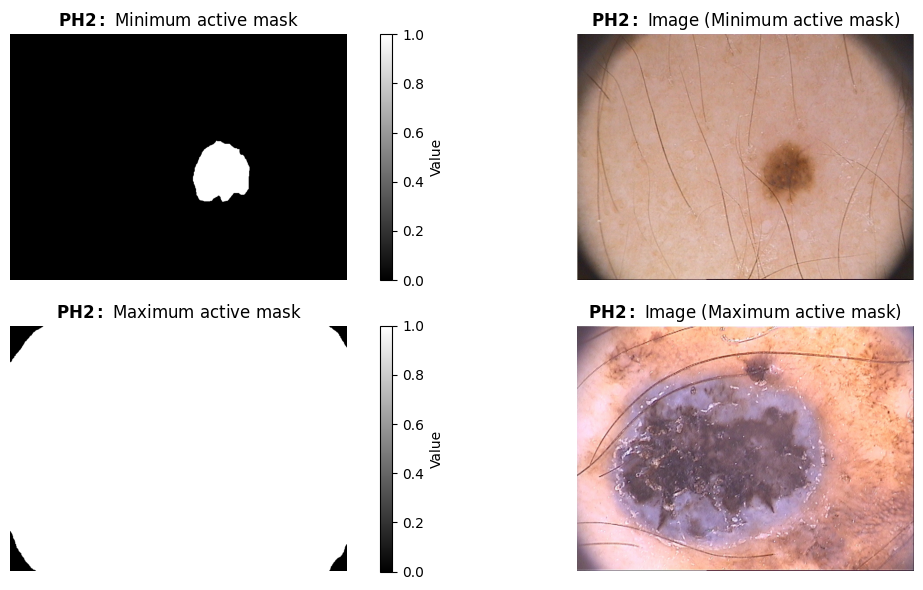

In [344]:
fig, axs = plt.subplots(2, 2, figsize=(16, 6))

im_min = axs[0, 0].imshow(labels[labels.sum(dim=(1,2,3)).argmin().item()].permute(1,2,0), cmap='gray', vmin=0.0, vmax=1.0)
axs[0, 0].axis('off')
axs[0, 0].set_title('$\mathbf{PH2:}$ Minimum active mask')

im_max = axs[1, 0].imshow(labels[labels.sum(dim=(1,2,3)).argmax().item()].permute(1,2,0), cmap='gray', vmin=0.0, vmax=1.0)
axs[1, 0].axis('off')
axs[1, 0].set_title('$\mathbf{PH2:}$ Maximum active mask')


axs[0, 1].imshow(data[labels.sum(dim=(1,2,3)).argmin().item()].permute(1,2,0))
axs[0, 1].axis('off')
axs[0, 1].set_title('$\mathbf{PH2:}$ Image (Minimum active mask)')


axs[1, 1].imshow(data[labels.sum(dim=(1,2,3)).argmax().item()].permute(1,2,0))
axs[1, 1].axis('off')
axs[1, 1].set_title('$\mathbf{PH2:}$ Image (Maximum active mask)')

cbar = plt.colorbar(im_min, ax=axs[0, 0], fraction=0.046, pad=0.04)
cbar.set_label('Value')

cbar = plt.colorbar(im_max, ax=axs[1, 0], fraction=0.046, pad=0.04)
cbar.set_label('Value')

plt.tight_layout()
plt.show()